In [1]:
import gym
import random
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import matplotlib.pyplot as plt
from threading import Thread

%matplotlib notebook

Using TensorFlow backend.


In [2]:
class DQNAgent:
    def __init__(self,state_size,action_size,epsilon,epsilon_decay):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = 100
        self.learning_rate = 0.0001
        self.Epsilon = epsilon
        self.Gamma = 0.7
        self.Epsilon_decay = epsilon_decay
        self.Epsilon_min = 0.001
        self.memory = deque(maxlen = 10000)
        self.model = self.buildModel()
    
    def buildModel(self):
        model = Sequential()
        model.add(Dense(12,input_dim = self.state_size,activation = 'relu'))
        model.add(Dense(6,activation = 'relu'))
        model.add(Dense(self.action_size,activation = 'softmax'))
        model.compile(loss = 'mse', optimizer = Adam(lr = self.learning_rate))
        return model
    
    def chooseAction(self,state):
        if (np.random.uniform() <= self.Epsilon):
            return random.randrange(self.action_size)
        action = self.model.predict(state)
        return np.argmax(action)
    
    def store(self,state,action,reward,next_state,done):
        self.memory.append((state,action,reward,next_state,done))
    
    def replay(self):
        if (len(self.memory)<self.batch_size):
            batch = random.sample(self.memory,len(self.memory))
        else:
            batch = random.sample(self.memory,self.batch_size)
        cost = 0
        loss = np.array([])
        for state,action,reward,next_state,done in batch:
            if done:
                target  = reward
            else:
                target = reward + self.Gamma * np.amax(self.model.predict(next_state))
            current = self.model.predict(state)
            cost += abs(target - current[0][action])
            current[0][action] = target
            loss = np.append(loss,self.model.fit(state,current,epochs=1,verbose=0).history['loss'])
        if (self.Epsilon > self.Epsilon_min):
            self.Epsilon *= self.Epsilon_decay
        return loss
        
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)
        

In [3]:
np.random.seed(2)
Episodes = 10000

In [4]:
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print (state_size,action_size)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
8 4


In [81]:
agent = DQNAgent(state_size,action_size,1.0,0.999)

<IPython.core.display.Javascript object>


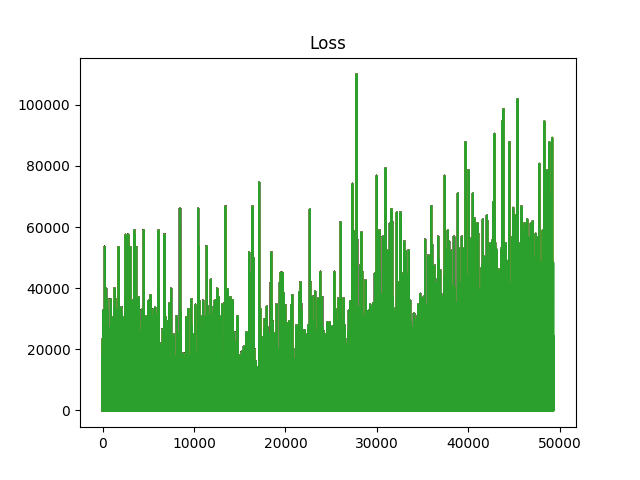

In [ ]:
done = False
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.title.set_text('Loss')
plt.ion()
fig.show()
fig.canvas.draw()
data = np.array([])
t = Thread(target = agent.replay())
for e in range(Episodes):
    state = env.reset()
    state = np.reshape(state, [1,state_size])
    steps = 0
    total_reward = 0
    for time in range(1000):
        if ()env.render()
        action = agent.chooseAction(state)
        if action != 1:
            steps +=1
        next_state,reward,done,_ = env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.store(state,action,total_reward,next_state,done)
        state = next_state
        if done:
            break
    loss = agent.replay()
    data = np.append(data,loss)
    ax1.plot(data)
    fig.canvas.draw()
    if total_reward >= 0:
        print("Episode: {}/{}, e: {:.2}, Time: {}, Reward: {},Steps: {}"
          .format(e, Episodes, agent.Epsilon,time,total_reward,steps),end = '\n')            
    else:
        print("Episode: {}/{}, e: {:.2}, Time: {}, Reward: {},Steps: {}::"
          .format(e, Episodes, agent.Epsilon,time,total_reward,steps),end = '\r')                 
env.close()

In [67]:
env.close()

In [73]:
agent.save("Lunar_lander-dqn.h5")